# **Summary - Milestone 2**:

- Make a **Data Exploration** notebook giving:
  *   Some visualization of the data.
  *   Some descriptive statistics (including biases in labels)
  *   Explain what you are doing in text cells.

- Discuss missing, imbalanced, or sparse data problems.

<br>

**Team Contributions**

The work of this notebook was distributed as follows:

| Name              | Contribution | Details                    |
|-------------------|--------------|----------------------------|
| Shashank Kushwaha |    25%       | Coordinate the group, started draft of `Data Exploration` code, further cleaned data.   |
| Johann J Cardenas |    25%       | Debugged missing values, added visualizations, extended analysis.  |
| Manoj Lakshmi     |    25%       | Enhanced overall code, finalized data cleaning and analized initial features   |
| Nghia Dai Nguyen  |    25%       | Refined code to speed up data loading, merged datasets and checked data analysis |

This distribution of effort was approved by

- Shashank Kushwaha (sk89@illinois.edu )
- Johann Cardenas Huaman (johannc2@illinois.edu)
- Manoj Lakshmi (lmanoj2@illinois.edu)
- Nghia Dai Nguyen (nghiadn2@illinois.edu)

In [79]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from tqdm import tqdm
from functools import partial
from IPython.display import display

In [2]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Initilizing directory names
base_dir = 'drive/MyDrive/Deep_Dive_Project_Group_12'  # root directory
data_dir = os.path.join(base_dir, 'data_new')          # organized data directory

oes_dir = os.path.join(data_dir, 'occupational_employment_and_wage', 'processed')  # Data block, and description
csc_dir = os.path.join(data_dir, 'college_scorecard', 'processed') # Data block, and description
ncei_dir = os.path.join(data_dir, 'ncei_weather', 'processed') # Data block, and description

years = [
    2023, 2022, 2021, 2020, 2019, 2018, 2017,
    2016, 2015, 2014, 2013, 2012, 2011
]

# Data Loading
oes_df = pd.read_pickle(os.path.join(oes_dir, 'oes_all.pkl'))
csc_df = pd.read_pickle(os.path.join(csc_dir, 'csc_all.pkl'))
ncei_avg_temperature_df = pd.read_pickle(os.path.join(ncei_dir, 'avg_temperature.pkl'))
ncei_precipitation_df = pd.read_pickle(os.path.join(ncei_dir, 'precipitation.pkl'))

# Correct minor mistakes and compute US-wide values
csc_df['ST_FIPS'] = csc_df['ST_FIPS'].astype(float)
csc_df = csc_df.dropna()
csc_df['ST_FIPS'] = csc_df['ST_FIPS'].astype(int).astype(str)  # Convert to a string for consistency
csc_us_total = csc_df.groupby('YEAR').sum().reset_index()
csc_us_total['ST_FIPS'] = '99'   # US-wide total for college scorecard infromation
csc_df = pd.concat([csc_df, csc_us_total])

# Display all data
display(oes_df.head())
display(csc_df.head())
display(ncei_avg_temperature_df.head())
display(ncei_precipitation_df.head())

<ipython-input-3-40c70e8e993b>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csc_df['ST_FIPS'] = csc_df['ST_FIPS'].astype(int).astype(str)


,ANNUAL,AREA,AREA_TITLE,AREA_TYPE,A_MEAN,A_MEDIAN,A_PCT10,A_PCT25,A_PCT75,A_PCT90,...,LOC_QUOTIENT,MEAN_PRSE,NAICS,NAICS_TITLE,OWN_CODE,OCC_CODE,OCC_TITLE,PCT_TOTAL,TOT_EMP,YEAR
0,NaN,99,U.S.,1,65470.0,48060.0,29050.0,35660.0,76980.0,121470.0,...,NaN,0.3,000000,Cross-industry,1235,00-0000,All Occupations,NaN,151853870.0,2023
1,NaN,99,U.S.,1,137750.0,116880.0,54550.0,78330.0,169090.0,231620.0,...,NaN,0.5,000000,Cross-industry,1235,11-0000,Management Occupations,NaN,10495770.0,2023
2,NaN,99,U.S.,1,136100.0,103460.0,46400.0,66170.0,165500.0,NaN,...,NaN,0.9,000000,Cross-industry,1235,11-1000,Top Executives,NaN,3751510.0,2023
3,NaN,99,U.S.,1,258900.0,206680.0,80000.0,130840.0,NaN,NaN,...,NaN,0.7,000000,Cross-industry,1235,11-1010,Chief Executives,NaN,211230.0,2023
4,NaN,99,U.S.,1,258900.0,206680.0,80000.0,130840.0,NaN,NaN,...,NaN,0.7,000000,Cross-industry,1235,11-1011,Chief Executives,NaN,211230.0,2023


,ST_FIPS,CIP01,CIP03,CIP04,CIP05,CIP09,CIP10,CIP11,CIP12,CIP13,...,CIP45,CIP46,CIP47,CIP48,CIP49,CIP50,CIP51,CIP52,CIP54,YEAR
0,1,354.1131,198.8820,122.0148,13.4127,1528.7283,97.4206,1493.5226,870.6495,1497.6931,...,1308.3078,312.6039,1545.1082,877.9717,398.5827,1067.7441,7658.1845,7317.4292,264.8665,2023
1,10,180.4231,90.1117,16.1320,11.3360,243.6923,43.7961,315.5129,200.9316,494.7888,...,502.1366,5.6699,140.4078,1.0460,80.0744,180.1054,1612.9231,1298.6040,51.5609,2023
2,11,0.0000,44.1120,68.5326,99.3007,483.2339,7.8819,395.6531,203.1032,95.1131,...,2216.2472,0.0000,0.0000,0.0000,0.0000,241.0454,1316.1248,1533.8932,117.7755,2023
3,12,1046.9547,736.7295,217.3663,83.2485,3865.1505,1359.2007,5473.5923,7019.7381,2388.6538,...,3952.7436,1371.2960,6014.8861,2238.2160,2049.0920,5224.7547,31915.6391,19650.6059,415.3792,2023
4,13,565.6590,258.6609,154.8656,129.6666,2594.2849,572.0287,4034.0345,2284.1847,3332.0602,...,2764.7516,405.7401,1700.6930,521.4358,533.2350,3343.0324,10114.6453,11867.3322,589.5630,2023


,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,FIPS_CODE
0,65.3,64.0,64.2,64.9,65.4,64.5,65.0,65.3,64.6,62.0,62.6,64.9,63.8,1
1,60.7,61.2,62.1,62.6,60.3,62.3,63.0,62.2,61.8,62.3,60.5,62.1,60.3,4
2,62.9,61.2,61.4,61.2,61.2,61.2,62.5,62.8,61.4,58.7,59.6,63.6,61.8,5
3,58.2,60.1,60.4,60.5,58.4,60.1,60.3,60.1,60.8,61.5,59.3,59.5,57.4,6
4,45.7,46.2,47.5,47.3,45.3,47.2,47.9,47.3,47.4,46.1,45.1,48.3,45.4,8


,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,FIPS_CODE
0,51.15,57.85,65.16,68.67,56.30,64.40,64.19,45.01,61.36,56.03,64.70,53.38,50.71,1
1,11.04,12.07,12.57,6.56,14.69,11.67,9.47,12.28,14.39,11.07,12.13,9.56,9.63,4
2,52.36,51.69,50.23,63.82,65.65,64.32,50.26,50.44,67.31,47.91,54.24,39.81,55.84,5
3,27.38,14.10,18.93,12.07,29.12,18.09,28.17,25.73,15.04,19.90,7.93,23.45,18.79,6
4,19.05,16.48,17.10,12.23,18.91,14.96,18.91,17.08,21.73,19.14,18.79,12.31,17.62,8


## **Data Fusion**

#### **`ANNUAL` and `HOURLY` features**

> **Description**
> - `ANNUAL`: Contains "TRUE" if only annual wages are released. The OEWS program releases only annual wages for some occupations that typically work fewer than 2,080 hours per year, but are paid on an annual basis, such as teachers, pilots, and athletes.
> - `HOURLY`: Contains "TRUE" if only hourly wages are released. The OEWS program releases only hourly wages for some occupations that typically work fewer than 2,080 hours per year and are paid on an hourly basis, such as actors, dancers, and musicians and singers.


- If `ANNUAL = 1 (TRUE)`, then only annual wage is released => hourly wage is `NaN`
- If `HOURLY = 1 (TRUE)`, then only hourly wage is released => annual wage is `NaN`

We can simply ignore these columns since the missingness can be inferred directly from the data.

In [4]:
display(oes_df[oes_df['HOURLY'] == 1]['A_MEAN'].unique())
display(oes_df[oes_df['ANNUAL'] == 1]['H_MEAN'].unique())

array([nan])

array([nan])

#### **Choosing valid states**

For this dataset, we would only consider state-level data and also the aggregated data for the entire US. For weather data, since we don't have records for Alaska and Hawaii, we would also omit these two states from the final dataset.

Therefore, the final dataset will be based on the following characteristics:
- **Geographical Information**: From 48 states and US-wide
- **Timeframe:** From 2011 to 2023
- **Job Market**: All valid jobs

In [5]:
# Identify valid `FIPS` codes that exist in all datasets for consistent cross-referencing

valid_fips = (
    set(oes_df['AREA'].unique())
    & set(csc_df['ST_FIPS'].unique())
    & set(ncei_avg_temperature_df['FIPS_CODE'].astype(str).unique())
    & set(ncei_precipitation_df['FIPS_CODE'].astype(str).unique())
)
print('Number of valid FIPS', len(valid_fips))

Number of valid FIPS 49


#### **Combine all datasets**

We will then map the number of new graduates and weather (average temperature and precipitation) data into the final dataset.
- We will use the available crosswalk data from here to perform mapping: https://nces.ed.gov/ipeds/cip
- Since the field of study to occupation mapping is many to many, we would only consider the agggregate data from one major field of study to one major group of occupation. We can reasonable argue that the workforce is "potential" workforce and the number is descriptive to describe this workforce despite duplications

In [6]:
'''
Since accessing a dictionary is faster, so we organize the remaining dataframes (which are very small)
into dictionaries for easier data retrieval.
'''

year2fips2cip2degree = {}
year2fips2temperature = {}
year2fips2precipitation = {}

for _, row in csc_df.iterrows():
    row_dict = row.to_dict()

    year = row_dict['YEAR']
    fips = row_dict['ST_FIPS']

    cip2degree = {
        key[3:]: value
        for key, value in row_dict.items()
        if key.startswith('CIP')
    }

    if fips == 99: print(row)

    if year not in year2fips2cip2degree:
        year2fips2cip2degree[year] = {}
    if fips not in year2fips2cip2degree[year]:
        year2fips2cip2degree[year][fips] = {}

    year2fips2cip2degree[year][fips].update(cip2degree)

for _, row in ncei_avg_temperature_df.iterrows():
    row_dict = row.to_dict()

    fips = str(int(row_dict['FIPS_CODE']))

    for key, value in row_dict.items():
        if key == 'FIPS_CODE': continue

        year = int(key)
        if year not in year2fips2temperature:
            year2fips2temperature[year] = {}
        if fips not in year2fips2temperature[year]:
            year2fips2temperature[year][fips] = {}

        year2fips2temperature[year][fips] = value

for _, row in ncei_precipitation_df.iterrows():
    row_dict = row.to_dict()

    fips = str(int(row_dict['FIPS_CODE']))

    for key, value in row_dict.items():
        if key == 'FIPS_CODE': continue

        year = int(key)
        if year not in year2fips2precipitation:
            year2fips2precipitation[year] = {}
        if fips not in year2fips2precipitation[year]:
            year2fips2precipitation[year][fips] = {}

        year2fips2precipitation[year][fips] = value

Now, we can map the **Standard Occupational Classification** (SOC) codes to **Classification of Instructional Programs** (CIP) codes, facilitating the link betwee educational and occupational data.

In [44]:
cip_soc_crosswalk_df = pd.read_excel(
    os.path.join(data_dir, 'cip2020_soc2018_crosswalk.xlsx'), sheet_name=1,
    dtype=str
)

soc_keys = cip_soc_crosswalk_df['SOC2018Code'].str[:2].unique()
soc_to_cip = {key: set() for key in soc_keys}

for _, row in cip_soc_crosswalk_df.iterrows():
    soc_to_cip[row['SOC2018Code'][:2]].add(row['CIP2020Code'][:2])

display(cip_soc_crosswalk_df)

,CIP2020Code,CIP2020Title,SOC2018Code,SOC2018Title
0,01.0000,"Agriculture, General.",19-1011,Animal Scientists
1,01.0000,"Agriculture, General.",19-1012,Food Scientists and Technologists
2,01.0000,"Agriculture, General.",19-1013,Soil and Plant Scientists
3,01.0000,"Agriculture, General.",19-4012,Agricultural Technicians
4,01.0000,"Agriculture, General.",25-1041,"Agricultural Sciences Teachers, Postsecondary"
...,...,...,...,...
6092,99.9999,NO MATCH,55-2012,First-Line Supervisors of Weapons Specialists/...
6093,99.9999,NO MATCH,55-2013,First-Line Supervisors of All Other Tactical O...
6094,99.9999,NO MATCH,55-3011,Air Crew Members
6095,99.9999,NO MATCH,55-3013,Armored Assault Vehicle Crew Members


In [9]:
# Rename the columns for easier inspection

tqdm.pandas(desc='Processing Dataframe')

feature_column_names = {
    'AREA': 'feature.area_code',
    'AREA_TITLE': 'feature.area_title',
    'NAICS': 'feature.naics_code',
    'NAICS_TITLE': 'feature.naics_title',
    'OCC_CODE': 'feature.occupation_code',
    'OCC_TITLE': 'feature.occupation_title',
    'TOT_EMP': 'feature.total_employees',
    'PCT_TOTAL': 'feature.percentage_total',
    'YEAR': 'feature.year'
}
label_column_names = {
    'H_MEAN': 'label.mean_hourly_wage',
    'A_MEAN': 'label.mean_annual_wage'
}

merged_df = oes_df[oes_df['AREA'].isin(valid_fips)][
    list(feature_column_names.keys())
    + list(label_column_names.keys())
]
merged_df = merged_df.rename(columns=feature_column_names)
merged_df = merged_df.rename(columns=label_column_names)

def get_college_degree(row):
    cips = soc_to_cip.get(row['feature.occupation_code'][:2])
    if cips is None: return np.nan

    year = row['feature.year']
    fips = row['feature.area_code']

    num_degrees = 0
    for cip in cips:
        num_degrees += year2fips2cip2degree[year][fips].get(cip, 0)

    return num_degrees

def get_avg_temperature(row):
    year, fips = row['feature.year'], row['feature.area_code']

    if fips not in valid_fips: return np.nan
    return year2fips2temperature[year][fips]

def get_precipitation(row):
    year, fips = row['feature.year'], row['feature.area_code']

    if fips not in valid_fips: return np.nan
    return year2fips2precipitation[year][fips]

merged_df['feature.new_college_degree'] = merged_df.progress_apply(get_college_degree, axis=1)
merged_df['feature.avg_temperature'] = merged_df[['feature.year', 'feature.area_code']].progress_apply(get_avg_temperature, axis=1)
merged_df['feature.precipitation'] = merged_df[['feature.year', 'feature.area_code']].progress_apply(get_precipitation, axis=1)


merged_df = merged_df.drop_duplicates() # each entry should be unique in this form
merged_df = merged_df.reset_index(drop=True)

merged_df

Processing Dataframe: 100%|██████████| 2661307/2661307 [00:34<00:00, 78123.04it/s]


,feature.area_code,feature.area_title,feature.naics_code,feature.naics_title,feature.occupation_code,feature.occupation_title,feature.total_employees,feature.percentage_total,feature.year,label.mean_hourly_wage,label.mean_annual_wage,feature.new_college_degree,feature.avg_temperature,feature.precipitation
0,99,U.S.,000000,Cross-industry,00-0000,All Occupations,151853870.0,NaN,2023,31.48,65470.0,NaN,54.37,29.54
1,99,U.S.,000000,Cross-industry,11-0000,Management Occupations,10495770.0,NaN,2023,66.23,137750.0,2.167487e+06,54.37,29.54
2,99,U.S.,000000,Cross-industry,11-1000,Top Executives,3751510.0,NaN,2023,65.43,136100.0,2.167487e+06,54.37,29.54
3,99,U.S.,000000,Cross-industry,11-1010,Chief Executives,211230.0,NaN,2023,124.47,258900.0,2.167487e+06,54.37,29.54
4,99,U.S.,000000,Cross-industry,11-1011,Chief Executives,211230.0,NaN,2023,124.47,258900.0,2.167487e+06,54.37,29.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633147,56,Wyoming,000000,Cross-industry,53-7071,Gas Compressor and Gas Pumping Station Operators,180.0,NaN,2011,27.08,56330.0,8.054832e+02,41.10,18.55
2633148,56,Wyoming,000000,Cross-industry,53-7073,Wellhead Pumpers,480.0,NaN,2011,20.64,42920.0,8.054832e+02,41.10,18.55
2633149,56,Wyoming,000000,Cross-industry,53-7081,Refuse and Recyclable Material Collectors,280.0,NaN,2011,14.82,30830.0,8.054832e+02,41.10,18.55
2633150,56,Wyoming,000000,Cross-industry,53-7111,Mine Shuttle Car Operators,80.0,NaN,2011,28.59,59460.0,8.054832e+02,41.10,18.55


In [10]:
# Save dataframe as pickle file
merged_df.to_pickle(os.path.join(data_dir, 'all.pkl'))

## **Basic Feature Analysis**

1. From **OES** data:
- `feature.area_code`: The code representing the area (FIPS code).
- `feature.area_title`: The name of the area.
- `feature.naics_code`: The NAICS (North American Industry Classification System) code representing the industry.
- `feature.naics_title`: The name of the industry corresponding to the NAICS code.
- `feature.occupation_code`: The SOC (Standard Occupational Classification) code representing the occupation.
- `feature.occupation_title`: The title of the occupation.
- `feature.total_employees`: The total number of employees in the occupation.
- `feature.percentage_total`: The percentage of total employees in the area.
- `feature.year`: The year the data was recorded.
2. Engineered Features:
- `feature.new_college_degree`: The number of college degrees awarded in related programs (CIP codes) for a given occupation.
- `feature.avg_temperature`: The average annual temperature for the area and year.
- `feature.precipitation`: The total annual precipitation for the area and year.

Such features can also be grouped in the following categories:
* **Area and Location Data**: `feature.area_code`, `feature.area_title`
* **Industry Data**: `feature.naics_code`, `feature.naics_title`
* **Occupation Data**: `feature.occupation_code`, `feature.occupation_title`
* **Employment Data**: `feature.total_employees`, `feature.percentage_total`
* **Year Data**: `feature.year`
* **Environmental Data**: `feature.avg_temperature`, `feature.precipitation`
* **Educational Data**: `feature.new_college_degree`

The team has the hypothesis that these are the most relevant features for predicting the `hourly wage` and `annual wage` of a person, and will test its hypothesis through extensive analysis in the next deliverables.

## **Data Exploration**

In [87]:
# Load pickle file
merged_df = pd.read_pickle(os.path.join(data_dir, 'all.pkl'))

In [88]:
# Visualize dataframe content
merged_df

,feature.area_code,feature.area_title,feature.naics_code,feature.naics_title,feature.occupation_code,feature.occupation_title,feature.total_employees,feature.percentage_total,feature.year,label.mean_hourly_wage,label.mean_annual_wage,feature.new_college_degree,feature.avg_temperature,feature.precipitation
0,99,U.S.,000000,Cross-industry,00-0000,All Occupations,151853870.0,NaN,2023,31.48,65470.0,NaN,54.37,29.54
1,99,U.S.,000000,Cross-industry,11-0000,Management Occupations,10495770.0,NaN,2023,66.23,137750.0,2.167487e+06,54.37,29.54
2,99,U.S.,000000,Cross-industry,11-1000,Top Executives,3751510.0,NaN,2023,65.43,136100.0,2.167487e+06,54.37,29.54
3,99,U.S.,000000,Cross-industry,11-1010,Chief Executives,211230.0,NaN,2023,124.47,258900.0,2.167487e+06,54.37,29.54
4,99,U.S.,000000,Cross-industry,11-1011,Chief Executives,211230.0,NaN,2023,124.47,258900.0,2.167487e+06,54.37,29.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633147,56,Wyoming,000000,Cross-industry,53-7071,Gas Compressor and Gas Pumping Station Operators,180.0,NaN,2011,27.08,56330.0,8.054832e+02,41.10,18.55
2633148,56,Wyoming,000000,Cross-industry,53-7073,Wellhead Pumpers,480.0,NaN,2011,20.64,42920.0,8.054832e+02,41.10,18.55
2633149,56,Wyoming,000000,Cross-industry,53-7081,Refuse and Recyclable Material Collectors,280.0,NaN,2011,14.82,30830.0,8.054832e+02,41.10,18.55
2633150,56,Wyoming,000000,Cross-industry,53-7111,Mine Shuttle Car Operators,80.0,NaN,2011,28.59,59460.0,8.054832e+02,41.10,18.55


### **Data Visualization**

#### Wage Distribution

First, let's observe if there is any considerable change in the wage range distribution over the years.

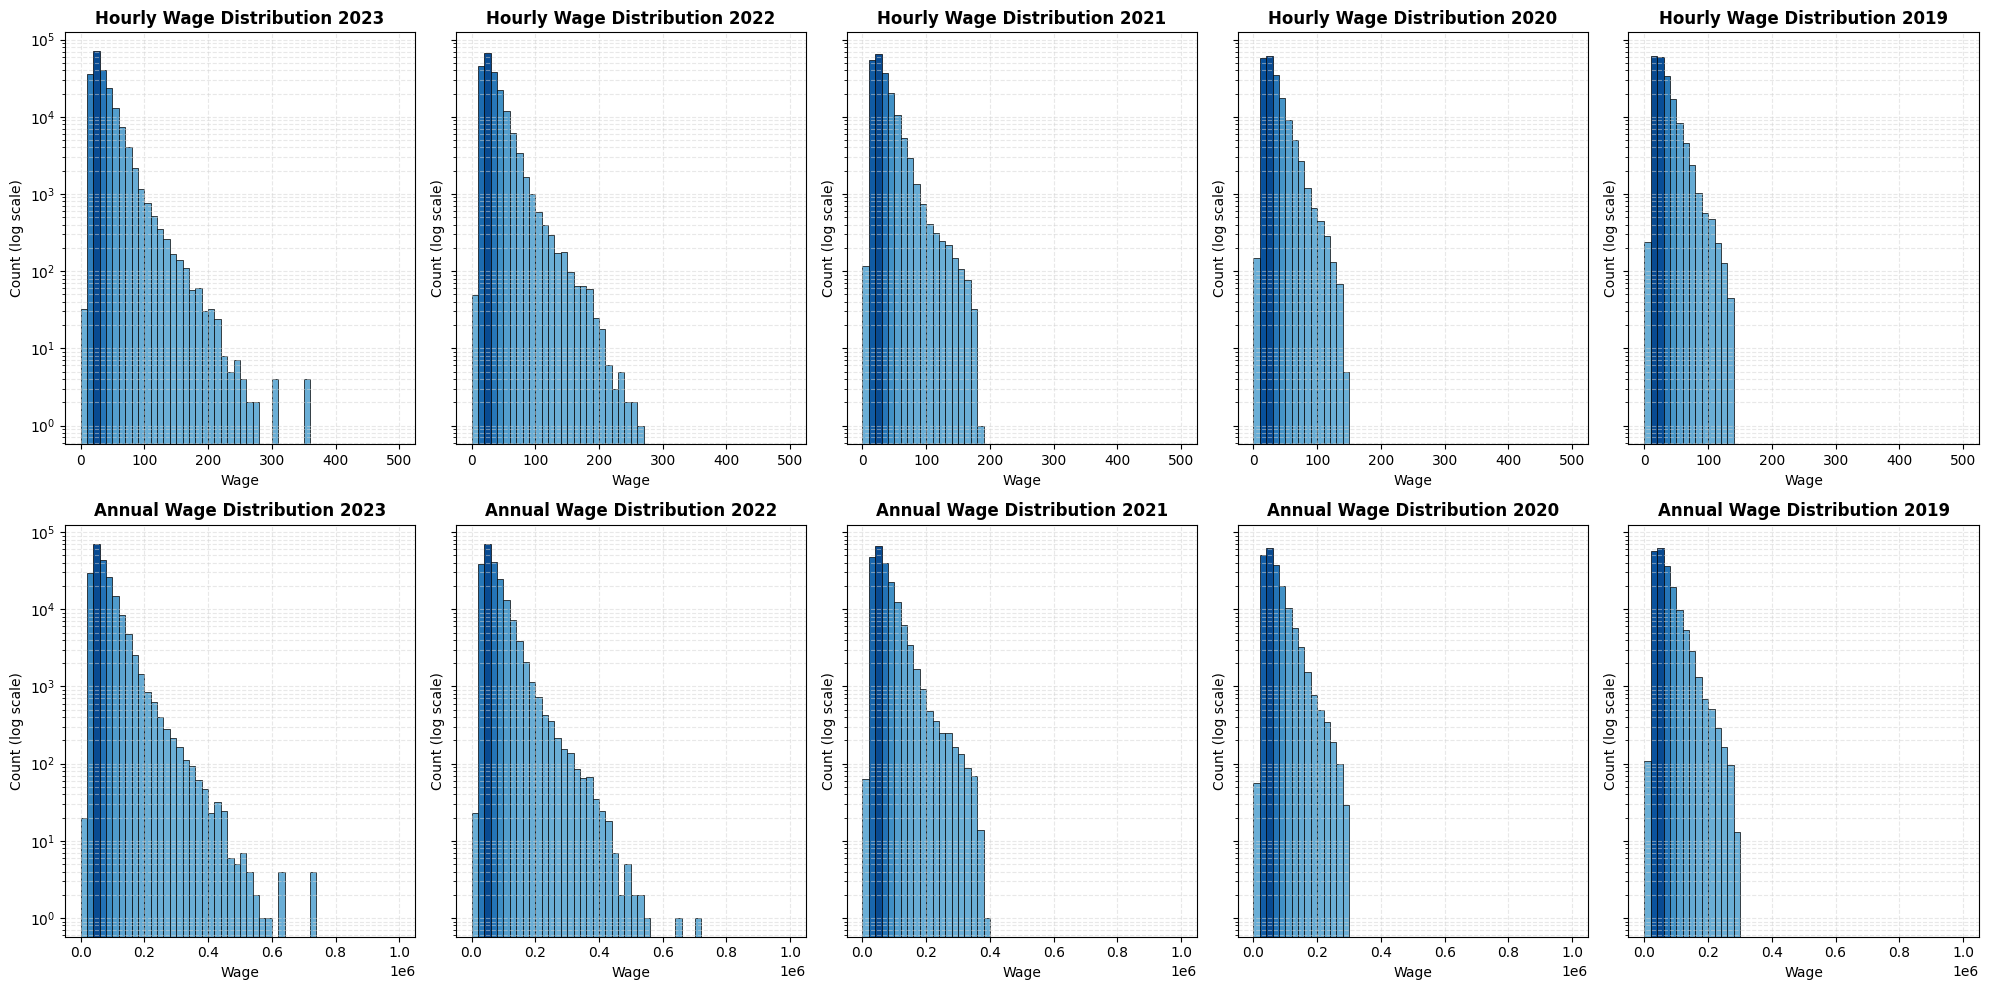

In [32]:
num_sub_plots = (2, 5)
plt.subplots(*num_sub_plots, figsize=(20, 10), sharey=True)
blues = matplotlib.colormaps['Blues']
custom_blues = blues(np.linspace(0.5, 0.9, 256))
viridis = ListedColormap(custom_blues)

for idx, year in enumerate(years[:5], start=1):
    subset_df = merged_df[merged_df['feature.year'] == year]

    # Hourly wage histogram
    plt.subplot(*num_sub_plots, idx)
    hist_data = subset_df['label.mean_hourly_wage'].dropna()
    n, bins, patches = plt.hist(hist_data, bins=50, range=(0, 500), log=True)

    # Normalize the color mapping for the current subplot
    norm = Normalize(vmin=0, vmax=max(n) if max(n) > 0 else 1)

    # Apply the colormap to the bars
    for bin_patch, value in zip(patches, n):
        color = viridis(norm(value))
        bin_patch.set_facecolor(color)
        bin_patch.set_edgecolor('black')
        bin_patch.set_linewidth(0.5)

    plt.title(f'Hourly Wage Distribution {year}', fontweight='bold')
    plt.xlabel('Wage')
    plt.ylabel('Count (log scale)')
    plt.grid(True, which='both', ls='--', color='lightgrey', alpha=0.50)

    # Annual wage histogram
    plt.subplot(*num_sub_plots, num_sub_plots[1] + idx)
    hist_data_annual = subset_df['label.mean_annual_wage'].dropna()
    n_annual, bins_annual, patches_annual = plt.hist(hist_data_annual, bins=50, range=(0, 1e6), log=True)

    # Normalize the color mapping for the current subplot
    norm_annual = Normalize(vmin=0, vmax=max(n_annual) if max(n_annual) > 0 else 1)

    # Apply the colormap to the bars
    for bin_patch, value in zip(patches_annual, n_annual):
        color = viridis(norm_annual(value))
        bin_patch.set_facecolor(color)
        bin_patch.set_edgecolor('black')
        bin_patch.set_linewidth(0.5)

    plt.title(f'Annual Wage Distribution {year}', fontweight='bold')
    plt.xlabel('Wage')
    plt.ylabel('Count (log scale)')
    plt.grid(True, which='both', ls='--', color='lightgrey', alpha=0.50)

plt.tight_layout()
plt.show()

#### Top Occupations and Industries

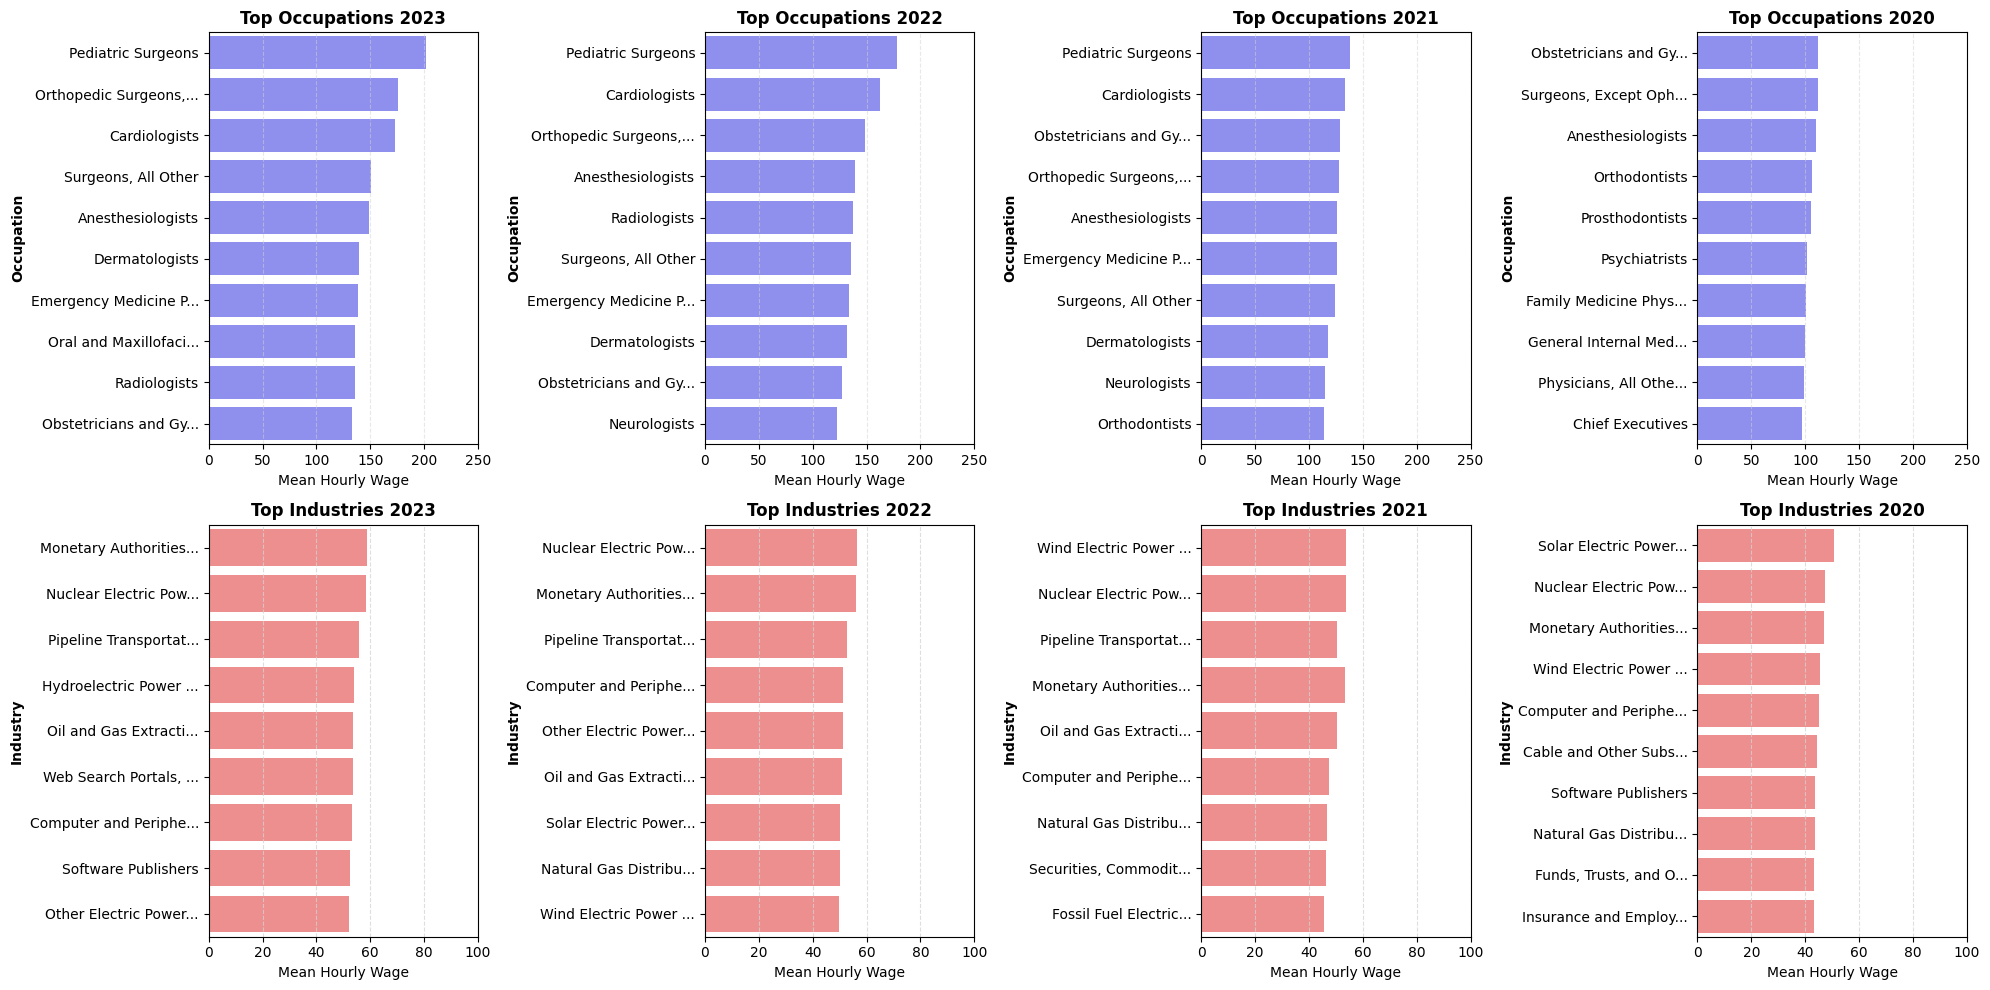

In [34]:
# Crop text function so that both subfigures are properly aligned
def crop_text(text, max_length=20):
    if len(text) > max_length:
        return text[:max_length] + '...'
    return text

num_sub_plots = (2, 4)

plt.subplots(*num_sub_plots, figsize=(20, 10))

for idx, year in enumerate(years[:4], start=1):
    subset_df = merged_df[merged_df['feature.year'] == year]

    by_occ_hourly = subset_df.groupby('feature.occupation_title')[
        ['label.mean_hourly_wage', 'label.mean_annual_wage']
    ].mean().sort_values(by='label.mean_hourly_wage', ascending=False)
    by_industry_hourly = subset_df.groupby('feature.naics_title')[
        ['label.mean_hourly_wage', 'label.mean_annual_wage']
    ].mean().sort_values(by='label.mean_hourly_wage', ascending=False)

    top10_occ_hourly = by_occ_hourly.head(10)['label.mean_hourly_wage']
    top10_industry_hourly = by_industry_hourly.head(10)['label.mean_hourly_wage']

    # Occupations
    plt.subplot(*num_sub_plots, idx)
    sns.barplot(
        x=top10_occ_hourly,
        y=list(map(crop_text, top10_occ_hourly.index)),
        color='blue',
        errorbar=None,
        alpha=0.5
    )
    plt.title(f'Top Occupations {year}', fontweight = 'bold')
    plt.xlabel('Mean Hourly Wage')
    plt.xlim(0, 250)
    plt.ylabel('Occupation', fontweight = 'bold')
    plt.grid(axis='x', which='major', linestyle='--', color='lightgrey', alpha=0.5)

    # Industries
    plt.subplot(*num_sub_plots, num_sub_plots[1] + idx)
    sns.barplot(
        x=top10_industry_hourly,
        y=list(map(crop_text, top10_industry_hourly.index)),
        color='red',
        alpha=0.5,
        errorbar=None
    )
    plt.title(f'Top Industries {year}', fontweight = 'bold')
    plt.xlabel('Mean Hourly Wage')
    plt.xlim(0, 100)
    plt.ylabel('Industry', fontweight = 'bold')
    plt.grid(axis='x', which='major', linestyle='--', color='lightgrey', alpha=0.75)

plt.tight_layout()
plt.show()

In [35]:
# Basic statistics for wage columns
merged_df[['label.mean_hourly_wage', 'label.mean_annual_wage']].describe()

,label.mean_hourly_wage,label.mean_annual_wage
count,2.529852e+06,2.594636e+06
mean,2.852983e+01,5.967900e+04
std,1.594469e+01,3.312080e+04
min,7.870000e+00,1.637000e+04
25%,1.763000e+01,3.689000e+04
50%,2.418000e+01,5.081000e+04
75%,3.467000e+01,7.277000e+04
max,3.533800e+02,7.350200e+05


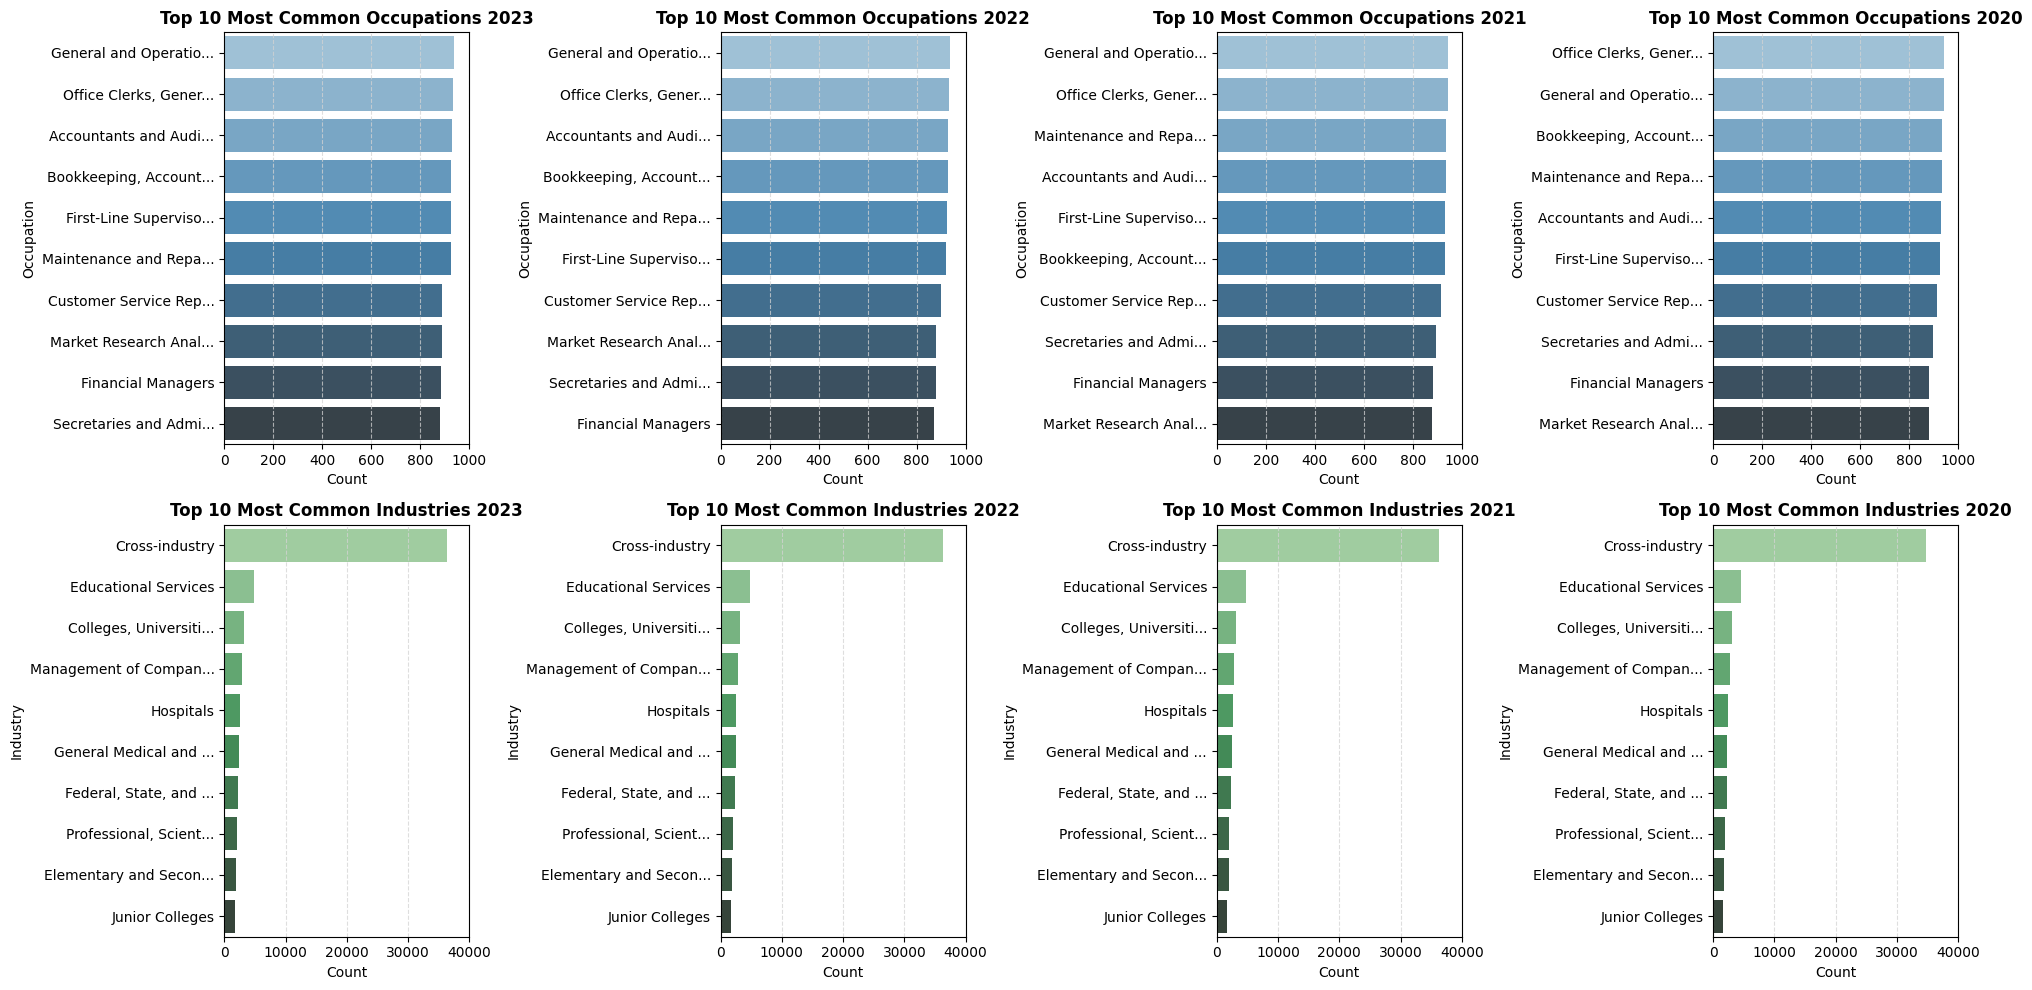

In [36]:
# Crop text function so that both subfigures are properly aligned
def crop_text(text, max_length=20):
    if len(text) > max_length:
        return text[:max_length] + '...'
    return text

num_sub_plots = (2, 4)

plt.subplots(*num_sub_plots, figsize=(20, 10))

for idx, year in enumerate(years[:4], start=1):
    subset_df = merged_df[merged_df['feature.year'] == year]

    occupation_counts = subset_df['feature.occupation_title'].value_counts()
    industry_counts = subset_df['feature.naics_title'].value_counts()

    # Top 10 Occupations
    plt.subplot(*num_sub_plots, idx)
    sns.barplot(
        x=occupation_counts.head(10).values,
        y=list(map(crop_text, occupation_counts.head(10).index)),
        hue=occupation_counts.head(10).index,
        palette="Blues_d",
        dodge=False,
        legend=False
    )
    plt.title(f'Top 10 Most Common Occupations {year}', fontweight='bold')
    plt.xlabel('Count')
    plt.xlim(0, 1e3)
    plt.ylabel('Occupation')
    plt.grid(axis='x', which='major', linestyle='--', color='lightgrey', alpha=0.75)

    # Top 10 Industries
    plt.subplot(*num_sub_plots, num_sub_plots[1] + idx)
    sns.barplot(
        x=industry_counts.head(10).values,
        y=list(map(crop_text, industry_counts.head(10).index)),
        hue=industry_counts.head(10).index,
        palette="Greens_d",
        dodge=False,
        legend=False
    )
    plt.title(f'Top 10 Most Common Industries {year}', fontweight='bold')
    plt.xlabel('Count')
    plt.xlim(0, 4e4)
    plt.ylabel('Industry')
    plt.grid(axis='x', which='major', linestyle='--', color='lightgrey', alpha=0.75)

plt.tight_layout()
plt.show()

### **NaNs Data Analysis**

The five columns that have missing values are:
- `feature.total_employees`
- `feature.percentage_total`
- `feature.new_college_degree`
- `label.mean_hourly_wage`
- `label.mean_annual_wage`

For now we will not drop the label as we will try to figure out how to deal with missing labels later.

In [37]:
merged_df.isna().sum(axis=0)

,0
feature.area_code,0
feature.area_title,0
feature.naics_code,0
feature.naics_title,0
feature.occupation_code,0
feature.occupation_title,0
feature.total_employees,132851
feature.percentage_total,650720
feature.year,0
label.mean_hourly_wage,103300


For new college degree, the generic category of `All occupations` does not have the required data. We will drop all these rows

In [38]:
display(merged_df[merged_df['feature.new_college_degree'].isna()])
display(merged_df[merged_df['feature.new_college_degree'].isna()]['feature.occupation_code'].value_counts())

,feature.area_code,feature.area_title,feature.naics_code,feature.naics_title,feature.occupation_code,feature.occupation_title,feature.total_employees,feature.percentage_total,feature.year,label.mean_hourly_wage,label.mean_annual_wage,feature.new_college_degree,feature.avg_temperature,feature.precipitation
0,99,U.S.,000000,Cross-industry,00-0000,All Occupations,151853870.0,NaN,2023,31.48,65470.0,NaN,54.37,29.54
1396,99,U.S.,000001,"Cross-industry, Private Ownership only",00-0000,All Occupations,130039030.0,NaN,2023,31.10,64680.0,NaN,54.37,29.54
2770,99,U.S.,11,"Agriculture, Forestry, Fishing and Hunting",00-0000,All Occupations,413580.0,100.0,2023,20.68,43010.0,NaN,54.37,29.54
3103,99,U.S.,21,"Mining, Quarrying, and Oil and Gas Extraction",00-0000,All Occupations,571160.0,100.0,2023,37.03,77020.0,NaN,54.37,29.54
3617,99,U.S.,22,Utilities,00-0000,All Occupations,564750.0,100.0,2023,46.76,97250.0,NaN,54.37,29.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629658,51,Virginia,000000,Cross-industry,00-0000,All Occupations,3553360.0,NaN,2011,23.50,48870.0,NaN,57.00,48.30
2630434,53,Washington,000000,Cross-industry,00-0000,All Occupations,2720660.0,NaN,2011,24.17,50280.0,NaN,45.50,43.82
2631199,54,West Virginia,000000,Cross-industry,00-0000,All Occupations,700250.0,NaN,2011,17.42,36220.0,NaN,53.50,55.10
2631859,55,Wisconsin,000000,Cross-industry,00-0000,All Occupations,2645180.0,NaN,2011,19.92,41420.0,NaN,44.10,31.04


,count
feature.occupation_code,
00-0000,6722


Most of the empty rows of total_employees are from the aggreegated US area (code 99). We can drop them.

In [39]:
display(merged_df[merged_df['feature.total_employees'].isna()])
display(merged_df[merged_df['feature.total_employees'].isna()]['feature.area_code'].value_counts())

,feature.area_code,feature.area_title,feature.naics_code,feature.naics_title,feature.occupation_code,feature.occupation_title,feature.total_employees,feature.percentage_total,feature.year,label.mean_hourly_wage,label.mean_annual_wage,feature.new_college_degree,feature.avg_temperature,feature.precipitation
1568,99,U.S.,000001,"Cross-industry, Private Ownership only",17-2020,Agricultural Engineers,NaN,NaN,2023,45.49,94620.0,974763.3896,54.37,29.54
1569,99,U.S.,000001,"Cross-industry, Private Ownership only",17-2021,Agricultural Engineers,NaN,NaN,2023,45.49,94620.0,974763.3896,54.37,29.54
1592,99,U.S.,000001,"Cross-industry, Private Ownership only",17-2150,"Mining and Geological Engineers, Including Min...",NaN,NaN,2023,49.99,103980.0,974763.3896,54.37,29.54
1593,99,U.S.,000001,"Cross-industry, Private Ownership only",17-2151,"Mining and Geological Engineers, Including Min...",NaN,NaN,2023,49.99,103980.0,974763.3896,54.37,29.54
1596,99,U.S.,000001,"Cross-industry, Private Ownership only",17-2170,Petroleum Engineers,NaN,NaN,2023,71.71,149160.0,974763.3896,54.37,29.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633061,56,Wyoming,000000,Cross-industry,49-3091,Bicycle Repairers,NaN,NaN,2011,13.11,27260.0,2377.4151,41.10,18.55
2633072,56,Wyoming,000000,Cross-industry,49-9062,Medical Equipment Repairers,NaN,NaN,2011,18.73,38960.0,2377.4151,41.10,18.55
2633088,56,Wyoming,000000,Cross-industry,51-3093,Food Cooking Machine Operators and Tenders,NaN,NaN,2011,10.57,21990.0,3330.9218,41.10,18.55
2633099,56,Wyoming,000000,Cross-industry,51-6099,"Textile, Apparel, and Furnishings Workers, All...",NaN,NaN,2011,13.46,28000.0,3330.9218,41.10,18.55


,count
feature.area_code,
99,117572
44,528
4,445
10,424
51,424
32,423
9,422
50,414
8,411


Most of the missing percetage_total rows are from the general 00 area of naics code. We can also drop them

In [40]:
display(merged_df[merged_df['feature.percentage_total'].isna()])
display(merged_df[merged_df['feature.percentage_total'].isna()]['feature.naics_code'].str[:2].value_counts())

,feature.area_code,feature.area_title,feature.naics_code,feature.naics_title,feature.occupation_code,feature.occupation_title,feature.total_employees,feature.percentage_total,feature.year,label.mean_hourly_wage,label.mean_annual_wage,feature.new_college_degree,feature.avg_temperature,feature.precipitation
0,99,U.S.,000000,Cross-industry,00-0000,All Occupations,151853870.0,NaN,2023,31.48,65470.0,NaN,54.37,29.54
1,99,U.S.,000000,Cross-industry,11-0000,Management Occupations,10495770.0,NaN,2023,66.23,137750.0,2.167487e+06,54.37,29.54
2,99,U.S.,000000,Cross-industry,11-1000,Top Executives,3751510.0,NaN,2023,65.43,136100.0,2.167487e+06,54.37,29.54
3,99,U.S.,000000,Cross-industry,11-1010,Chief Executives,211230.0,NaN,2023,124.47,258900.0,2.167487e+06,54.37,29.54
4,99,U.S.,000000,Cross-industry,11-1011,Chief Executives,211230.0,NaN,2023,124.47,258900.0,2.167487e+06,54.37,29.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633147,56,Wyoming,000000,Cross-industry,53-7071,Gas Compressor and Gas Pumping Station Operators,180.0,NaN,2011,27.08,56330.0,8.054832e+02,41.10,18.55
2633148,56,Wyoming,000000,Cross-industry,53-7073,Wellhead Pumpers,480.0,NaN,2011,20.64,42920.0,8.054832e+02,41.10,18.55
2633149,56,Wyoming,000000,Cross-industry,53-7081,Refuse and Recyclable Material Collectors,280.0,NaN,2011,14.82,30830.0,8.054832e+02,41.10,18.55
2633150,56,Wyoming,000000,Cross-industry,53-7111,Mine Shuttle Car Operators,80.0,NaN,2011,28.59,59460.0,8.054832e+02,41.10,18.55


,count
feature.naics_code,
00,483451
99,51452
62,10847
56,10655
44,8213
81,7896
54,7882
23,7627
42,7443


In [41]:
filtered_df = merged_df.dropna(subset=['feature.total_employees', 'feature.percentage_total', 'feature.new_college_degree']).reset_index(drop=True)
filtered_df

,feature.area_code,feature.area_title,feature.naics_code,feature.naics_title,feature.occupation_code,feature.occupation_title,feature.total_employees,feature.percentage_total,feature.year,label.mean_hourly_wage,label.mean_annual_wage,feature.new_college_degree,feature.avg_temperature,feature.precipitation
0,99,U.S.,11,"Agriculture, Forestry, Fishing and Hunting",11-0000,Management Occupations,12040.0,2.91,2023,52.69,109590.0,2.167487e+06,54.37,29.54
1,99,U.S.,11,"Agriculture, Forestry, Fishing and Hunting",11-1000,Top Executives,6150.0,1.49,2023,52.40,108990.0,2.167487e+06,54.37,29.54
2,99,U.S.,11,"Agriculture, Forestry, Fishing and Hunting",11-1010,Chief Executives,130.0,0.03,2023,109.02,226760.0,2.167487e+06,54.37,29.54
3,99,U.S.,11,"Agriculture, Forestry, Fishing and Hunting",11-1011,Chief Executives,130.0,0.03,2023,109.02,226760.0,2.167487e+06,54.37,29.54
4,99,U.S.,11,"Agriculture, Forestry, Fishing and Hunting",11-1020,General and Operations Managers,6020.0,1.46,2023,51.16,106410.0,2.167487e+06,54.37,29.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976413,99,U.S.,999300,"Local Government, excluding schools and hospit...",53-7071,Gas Compressor and Gas Pumping Station Operators,90.0,0.00,2011,NaN,NaN,6.798904e+05,53.17,30.09
1976414,99,U.S.,999300,"Local Government, excluding schools and hospit...",53-7072,"Pump Operators, Except Wellhead Pumpers",270.0,0.00,2011,19.40,40340.0,6.798904e+05,53.17,30.09
1976415,99,U.S.,999300,"Local Government, excluding schools and hospit...",53-7081,Refuse and Recyclable Material Collectors,47000.0,0.85,2011,17.11,35590.0,6.798904e+05,53.17,30.09
1976416,99,U.S.,999300,"Local Government, excluding schools and hospit...",53-7121,"Tank Car, Truck, and Ship Loaders",40.0,0.00,2011,19.76,41100.0,6.798904e+05,53.17,30.09


In [42]:
filtered_df.isna().sum(axis=0)

,0
feature.area_code,0
feature.area_title,0
feature.naics_code,0
feature.naics_title,0
feature.occupation_code,0
feature.occupation_title,0
feature.total_employees,0
feature.percentage_total,0
feature.year,0
label.mean_hourly_wage,58660


Store filtered data in a new pickle file for easy retrieval:

In [43]:
filtered_df.to_pickle(os.path.join(data_dir, 'all_filtered.pkl'))